In [5]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, r2_score, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.cluster import HDBSCAN, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from scipy.optimize import curve_fit, minimize_scalar
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import gaussian_kde
from scipy import integrate
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

## Fungsi ubah ra-dec ke x y z (cartesian)

In [6]:
def radec_to_cartesian(ra, dec):
    """
    Convert RA/DEC coordinates to Cartesian coordinates (x, y, z)

    Parameters:
    -----------
    ra : array-like
        Right Ascension in degrees
    dec : array-like
        Declination in degrees

    Returns:
    --------
    x, y, z : numpy arrays
        Cartesian coordinates on unit sphere
    """
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)

    return x, y, z

## Membuat data training

Load data cluster berlabel, cari cluster yang paling banyak

In [7]:
Dset_lbl = pd.read_csv('star_cluster_problabeled.csv')

In [8]:
Dset_lbl.groupby('Cluster').count().sort_values(by='_r',ascending=False)

,_RAJ2000,_DEJ2000,_r,GaiaDR3,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,Pmemb
Cluster,,,,,,,,,,,,,
UBC_403,2407,2407,2407,2407,2407,2407,2407,2407,2407,2407,2407,2407,2407
King_13,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068
FSR_0451,1739,1739,1739,1739,1739,1739,1739,1739,1739,1739,1739,1739,1739
NGC_7788,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686
NGC_7790,1660,1660,1660,1660,1660,1660,1660,1660,1660,1660,1660,1660,1660
UBC1196,1650,1650,1650,1650,1650,1650,1650,1650,1650,1650,1650,1650,1650
UBC_405,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598,1598
UBC_406,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359
UBC_595,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344


UBC 403 akan dipakai

In [9]:
TGT = Dset_lbl.loc[Dset_lbl['Cluster'] == 'UBC_403']

Gunakan kriteria minima KDE untuk mencari ambang batas probabilitas

In [10]:
def find_kde_minimum(probabilities, plot=True):
    # Create KDE
    kde = gaussian_kde(probabilities)

    # Create high-resolution x-axis for smooth KDE curve
    x_range = np.linspace(0, 1, 2000)
    kde_values = kde(x_range)

    # Find minimum (avoiding edges to prevent boundary effects)
    interior_mask = (x_range > 0.05) & (x_range < 0.95)
    interior_x = x_range[interior_mask]
    interior_kde = kde_values[interior_mask]

    # Find minimum point
    min_idx = np.argmin(interior_kde)
    kde_threshold = interior_x[min_idx]
    kde_min_value = interior_kde[min_idx]

    print(f"KDE minimum found at: {kde_threshold:.3f}")

    # Create plot
    if plot:
        plt.figure(figsize=(10, 6))

        # Plot histogram
        plt.hist(probabilities, bins=50, density=True, alpha=0.6,
                color='lightblue', edgecolor='black', label='Original Distribution')

        # Plot KDE
        plt.plot(x_range, kde_values, 'red', linewidth=2, label='KDE')

        # Mark minimum
        plt.axvline(kde_threshold, color='green', linestyle='--', linewidth=2,
                   label=f'KDE Minimum: {kde_threshold:.3f}')
        plt.scatter(kde_threshold, kde_min_value, color='green', s=100, zorder=5)

        plt.xlabel('Membership Probability')
        plt.ylabel('Density')
        plt.title('Probability Distribution with KDE and Minimum Point')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    return kde_threshold

KDE minimum found at: 0.741


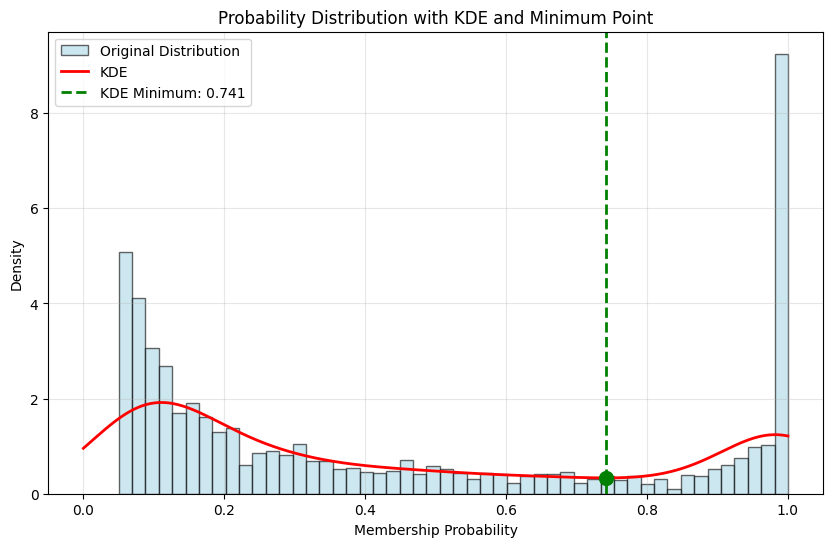

In [11]:
kde_threshold = find_kde_minimum(TGT['Pmemb'])

In [12]:
# Tambah kolom membership
TGT['membership_flag'] = np.where(TGT['Pmemb'] > 0.741, 1, 0)

In [13]:
# tambah kolom koordinat kartesian
TGT['x'], TGT['y'], TGT['z'] = radec_to_cartesian(TGT['_RAJ2000'], TGT['_DEJ2000'])

In [14]:
feature_columns = ['x','y','z','pmRA', 'pmDE', 'Plx']

In [15]:
ngc_77 = pd.read_csv('ngc7790_7788.csv')
ngc_77 = ngc_77.loc[ngc_77['RUWE'] < 1.4]
ngc_77['x'], ngc_77['y'], ngc_77['z'] = radec_to_cartesian(ngc_77['_RAJ2000'], ngc_77['_DEJ2000'])

ngc_77.dropna(subset=feature_columns)

,_RAJ2000,_DEJ2000,_r,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,...,APASS9,GSC23,RAVE5,2MASS,RAVE6,RAJ2000,DEJ2000,x,y,z
0,0.000255,61.202758,0.326354,0.000248,61.202742,2011889370096730624,0.1596,0.1348,0.8745,0.1853,...,NaN,NAL4019772,NaN,NaN,NaN,0.000255,61.202758,0.481711,0.000002,0.876330
1,0.005353,61.195030,0.331358,0.005349,61.195030,429483879057969152,0.2761,0.2607,-0.1351,0.3500,...,NaN,NAL4019523,NaN,NaN,NaN,0.005353,61.195030,0.481830,0.000045,0.876265
2,0.004781,61.197152,0.330331,0.004734,61.197134,429483879061852160,0.1210,0.1167,0.6195,0.1529,...,NaN,NAL4109846,NaN,NaN,NaN,0.004781,61.197152,0.481797,0.000040,0.876283
3,0.003850,61.194426,0.330898,0.003837,61.194423,429483879066750208,0.1727,0.1661,0.0297,0.2207,...,NaN,NaN,NaN,NaN,NaN,0.003850,61.194426,0.481839,0.000032,0.876260
5,0.004402,61.196131,0.330530,0.004385,61.196131,429483883360148864,0.1500,0.1456,0.0634,0.1901,...,NaN,NaN,NaN,00000107+6111462,NaN,0.004402,61.196131,0.481813,0.000037,0.876274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20432,359.863062,61.470416,0.287459,359.863043,61.470418,2011911463412488064,0.2990,0.2788,0.5285,0.3766,...,NaN,NaN,NaN,NaN,NaN,359.863062,61.470416,0.477611,-0.001142,0.878571
20433,359.881192,61.472258,0.295738,359.881176,61.472258,2011911463412490496,0.2536,0.2514,-0.3442,0.3146,...,NaN,N19G068405,NaN,NaN,NaN,359.881192,61.472258,0.477583,-0.000990,0.878586
20434,359.864039,61.464813,0.284830,359.864016,61.464808,2011911463412497536,0.5265,0.4208,-0.5284,0.6816,...,NaN,NaN,NaN,NaN,NaN,359.864039,61.464813,0.477697,-0.001134,0.878524
20435,359.865395,61.466389,0.286224,359.865377,61.466391,2011911463413487872,0.4946,0.4013,-0.1333,0.5965,...,NaN,NaN,NaN,NaN,NaN,359.865395,61.466389,0.477673,-0.001122,0.878537


In [16]:
# 1. Hitung pusat rata-rata PM dan Parallax untuk NGC 7790 (Target)
# Kita gunakan median agar tidak terpengaruh outlier bintang yang jauh
center_7790 = {
    'pmRA': ngc_77['pmRA'].median(),
    'pmDE': ngc_77['pmDE'].median(),
    'Plx': ngc_77['Plx'].median()
}

# 2. Buat kolom Delta (Selisih) pada dataframe NGC 7790
ngc_77['d_pmRA'] = ngc_77['pmRA'] - center_7790['pmRA']
ngc_77['d_pmDE'] = ngc_77['pmDE'] - center_7790['pmDE']
ngc_77['d_Plx'] = ngc_77['Plx'] - center_7790['Plx']

# 3. Lakukan hal yang sama pada data training (NGC 1624)
# (Gunakan rata-rata dari bintang yang SUDAH PASTI MEMBER)
mask_member = TGT['membership_flag'] == 1
center_1624 = {
    'pmRA': TGT[mask_member]['pmRA'].mean(),
    'pmDE': TGT[mask_member]['pmDE'].mean(),
    'Plx': TGT[mask_member]['Plx'].mean()
}

TGT['d_pmRA'] = TGT['pmRA'] - center_1624['pmRA']
TGT['d_pmDE'] = TGT['pmDE'] - center_1624['pmDE']
TGT['d_Plx'] = TGT['Plx'] - center_1624['Plx']

# 4. Update feature_columns kamu
# KITA HAPUS x, y, z (posisi langit) agar model hanya belajar "Pola Gerak"
feature_columns_relatif = ['d_pmRA', 'd_pmDE', 'd_Plx']

## Random Forest

### Training on UBC 403

In [17]:

X = TGT[feature_columns]
y = TGT['membership_flag']

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# scaling
scaler_A = StandardScaler()
X_train_scaled = scaler_A.fit_transform(X_train)
X_test_scaled = scaler_A.transform(X_test)

In [20]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1  # Use all available cores
)

In [21]:
# Train the model
print("\nTraining Random Forest classifier...")
rf_classifier.fit(X_train_scaled, y_train)


Training Random Forest classifier...


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [22]:
# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]

In [23]:
# Evaluate the model
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


MODEL EVALUATION
Accuracy: 0.8527

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       341
           1       0.86      0.60      0.70       141

    accuracy                           0.85       482
   macro avg       0.85      0.78      0.80       482
weighted avg       0.85      0.85      0.84       482


ROC AUC Score: 0.9215


In [24]:
# Cross-validation scores
cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-validation ROC AUC: 0.9175 (+/- 0.0347)


In [25]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
  feature  importance
5     Plx    0.245413
3    pmRA    0.188745
4    pmDE    0.179339
2       z    0.129616
0       x    0.129324
1       y    0.127564


In [26]:
"""# Hyperparameter tuning (optional)
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

param_grid = {
    'n_estimators': [300, 600, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing Grid Search (this may take a while)...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")"""

'# Hyperparameter tuning (optional)\nprint("\n" + "="*50)\nprint("HYPERPARAMETER TUNING")\nprint("="*50)\n\nparam_grid = {\n    \'n_estimators\': [300, 600, 1000],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\nprint("Performing Grid Search (this may take a while)...")\ngrid_search = GridSearchCV(\n    RandomForestClassifier(random_state=42, class_weight=\'balanced\'),\n    param_grid,\n    cv=3,\n    scoring=\'roc_auc\',\n    n_jobs=-1,\n    verbose=1\n)\n\ngrid_search.fit(X_train_scaled, y_train)\n\nprint(f"\nBest parameters: {grid_search.best_params_}")\nprint(f"Best cross-validation score: {grid_search.best_score_:.4f}")'

In [27]:
"""# Train final model with best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
y_pred_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_best))
print(f"\nImproved ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")"""

'# Train final model with best parameters\nbest_rf = grid_search.best_estimator_\ny_pred_best = best_rf.predict(X_test_scaled)\ny_pred_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]\n\nprint(classification_report(y_test, y_pred_best))\nprint(f"\nImproved ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")'

In [28]:
y_pred_best = y_pred
y_pred_proba_best = y_pred_proba
best_rf = rf_classifier

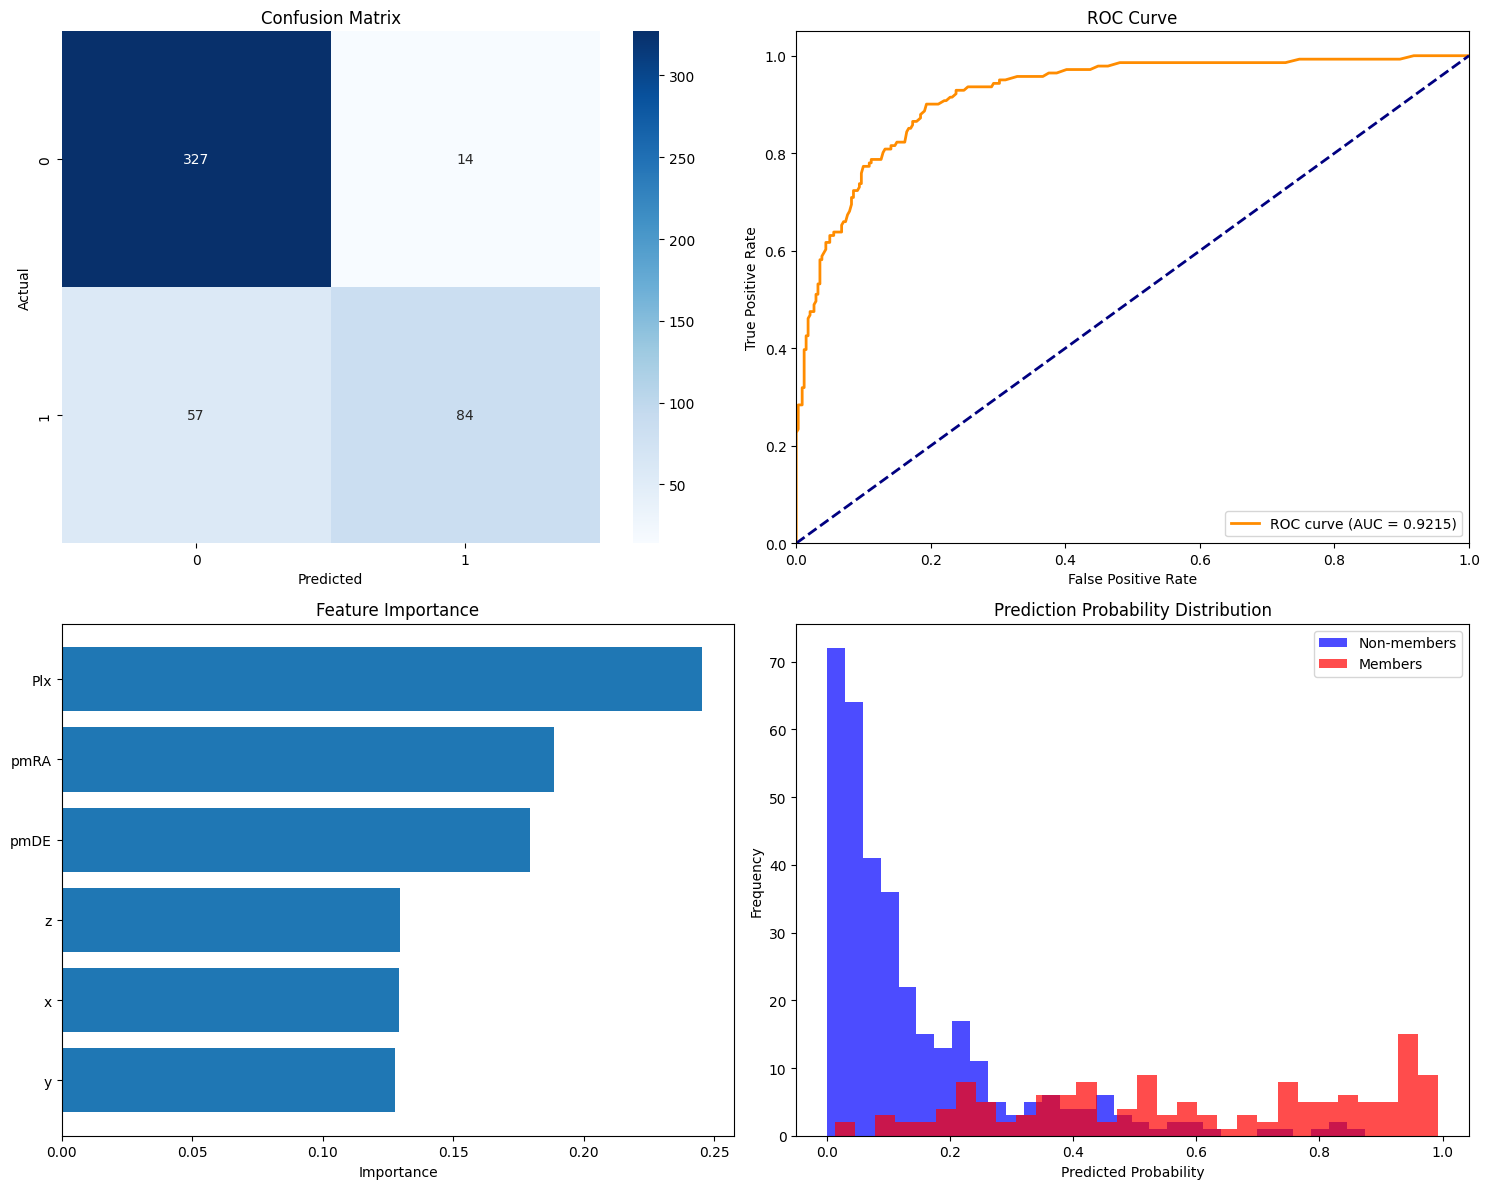

In [29]:
# Plotting results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
               label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_best):.4f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")

# 3. Feature Importance
feature_imp_best = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=True)

axes[1,0].barh(feature_imp_best['feature'], feature_imp_best['importance'])
axes[1,0].set_title('Feature Importance')
axes[1,0].set_xlabel('Importance')

# 4. Prediction Probability Distribution
axes[1,1].hist(y_pred_proba_best[y_test == 0], bins=30, alpha=0.7,
               label='Non-members', color='blue')
axes[1,1].hist(y_pred_proba_best[y_test == 1], bins=30, alpha=0.7,
               label='Members', color='red')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Prediction Probability Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [30]:
# Permutation importance (more reliable than built-in feature importance)
print("\n" + "="*50)
print("PERMUTATION IMPORTANCE")
print("="*50)

perm_importance = permutation_importance(
    best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42
)

perm_imp_df = pd.DataFrame({
    'feature': feature_columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Permutation Importance:")
print(perm_imp_df)


PERMUTATION IMPORTANCE
Permutation Importance:
  feature  importance_mean  importance_std
5     Plx         0.100000        0.014126
3    pmRA         0.075519        0.012996
4    pmDE         0.063485        0.011409
1       y         0.048755        0.011598
2       z         0.024689        0.010957
0       x         0.024066        0.011447


### Clustering on NGC 7790

In [31]:
def predict_cluster_membership(new_data, model=best_rf):
    """
    Predict cluster membership for new star data

    Parameters:
    new_data: DataFrame with columns ['pmRA', 'pmDE', '_RAJ2000', '_DEJ2000', 'd']

    Returns:
    predictions: array of 0s and 1s
    probabilities: array of probabilities for being a cluster member
    """
    # Scale the features
    scaler_B = StandardScaler()
    new_data_scaled = scaler_B.fit_transform(new_data[feature_columns])

    # Make predictions
    predictions = model.predict(new_data_scaled)
    probabilities = model.predict_proba(new_data_scaled)[:, 1]

    return predictions, probabilities

In [32]:
predictions, probabilities = predict_cluster_membership(ngc_77)

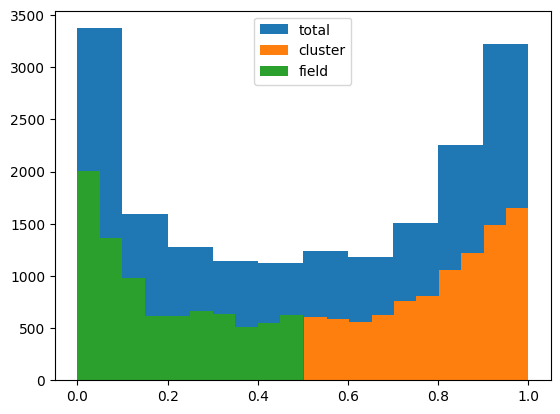

In [33]:
plt.hist(probabilities, label='total')
plt.hist(probabilities[predictions == 1], label='cluster')
plt.hist(probabilities[predictions == 0], label='field')
plt.legend()

In [34]:
ngc_77_RF = ngc_77.copy()
ngc_77_RF['Pmemb'] = probabilities
ngc_77_RF['membership'] = predictions

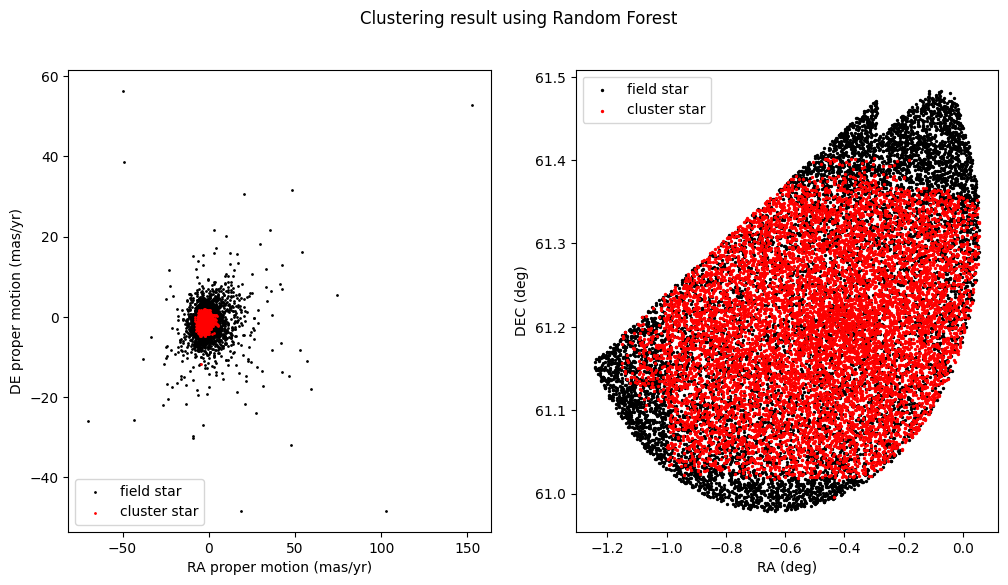

In [35]:
fig1, ax1 = plt.subplots(1,2,figsize=(12,6))
fig1.suptitle('Clustering result using Random Forest')

plt.sca(ax1[0])
plt.scatter(ngc_77_RF[ngc_77_RF.membership == 0]['pmRA'],ngc_77_RF[ngc_77_RF.membership == 0]['pmDE'],s=1,c='k',label='field star')
plt.scatter(ngc_77_RF[ngc_77_RF.membership == 1]['pmRA'],ngc_77_RF[ngc_77_RF.membership == 1]['pmDE'],s=1,c='r',label='cluster star')
plt.xlabel('RA proper motion (mas/yr)')
plt.ylabel('DE proper motion (mas/yr)')
plt.legend()

plt.sca(ax1[1])
plt.scatter(ngc_77_RF[(ngc_77_RF.membership == 0) & ( ngc_77_RF._RAJ2000 < 180)]['_RAJ2000'],
            ngc_77_RF[(ngc_77_RF.membership == 0) & ( ngc_77_RF._RAJ2000 < 180)]['_DEJ2000'],
            s=2,
            c='k',
            label='field star')
plt.scatter(ngc_77_RF[(ngc_77_RF.membership == 0) & ( ngc_77_RF._RAJ2000 >= 180)]['_RAJ2000'] - 360,
            ngc_77_RF[(ngc_77_RF.membership == 0) & ( ngc_77_RF._RAJ2000 >= 180)]['_DEJ2000'],
            s=2,
            c='k', )
plt.scatter(ngc_77_RF[(ngc_77_RF.membership == 1) & ( ngc_77_RF._RAJ2000 < 180)]['_RAJ2000'],
            ngc_77_RF[(ngc_77_RF.membership == 1) & ( ngc_77_RF._RAJ2000 < 180)]['_DEJ2000'],
            s=2,
            c='r',
            label='cluster star')
plt.scatter(ngc_77_RF[(ngc_77_RF.membership == 1) & ( ngc_77_RF._RAJ2000 >= 180)]['_RAJ2000'] -360,
            ngc_77_RF[(ngc_77_RF.membership == 1) & ( ngc_77_RF._RAJ2000 >= 180)]['_DEJ2000'],
            s=2,
            c='r',
            )
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

plt.legend()

plt.show()


## Support Vector Machine

In [36]:
# Prepare features and target for cluster A
X = TGT[feature_columns]
y = TGT['membership_flag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Scale the features
scaler_A = StandardScaler()
X_train_scaled = scaler_A.fit_transform(X_train)
X_test_scaled = scaler_A.transform(X_test)

In [37]:
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)
print("Training SVM model...")
svm_model.fit(X_train_scaled, y_train)
print("Training completed!")

Training SVM model...
Training completed!


Accuracy: 0.8651

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       341
           1       0.71      0.90      0.80       141

    accuracy                           0.87       482
   macro avg       0.83      0.88      0.85       482
weighted avg       0.88      0.87      0.87       482


Confusion Matrix:
[[290  51]
 [ 14 127]]


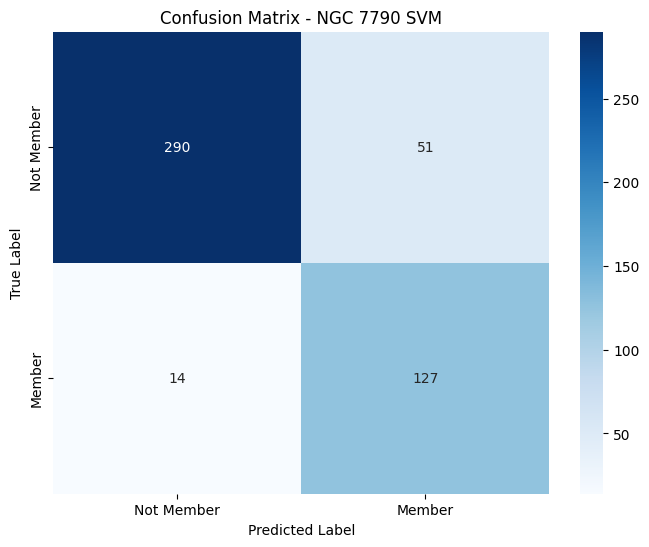

In [38]:
# Make predictions on test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Member', 'Member'],
            yticklabels=['Not Member', 'Member'])
plt.title('Confusion Matrix - NGC 7790 SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [39]:
scaler_B = StandardScaler()
X_ngc7790_SVM = scaler_B.fit_transform(ngc_77[feature_columns])

In [40]:
cluster_B_predictions = svm_model.predict(X_ngc7790_SVM)
cluster_B_probabilities = svm_model.decision_function(X_ngc7790_SVM)

Cluster B Prediction Summary:
Total stars: 17934
Predicted members: 12288 (68.52%)
Predicted non-members: 5646 (31.48%)

Sample predictions (first 10 stars):
           x             y         z   pmRA   pmDE     Plx  \
0   0.481711  2.144896e-06  0.876330 -0.786 -3.633  0.8745   
1   0.481830  4.501214e-05  0.876265 -0.427 -0.002 -0.1351   
2   0.481797  4.020181e-05  0.876283 -5.024 -4.020  0.6195   
3   0.481839  3.237362e-05  0.876260 -1.373 -0.555  0.0297   
5   0.481813  3.702005e-05  0.876274 -1.908  0.182  0.0634   
7   0.481777  3.255894e-05  0.876294  0.477 -1.105  0.2595   
8   0.481761  8.988681e-05  0.876303  0.600  0.900  0.0329   
9   0.481691  5.796480e-05  0.876341 -5.594 -6.093 -0.2999   
10  0.481610  6.950104e-05  0.876386 -7.260 -4.150  2.7990   
11  0.481706  4.805281e-07  0.876333 -3.509 -1.513  0.6925   

    predicted_membership  decision_score  
0                      0       -0.580659  
1                      1        0.851599  
2                      0      

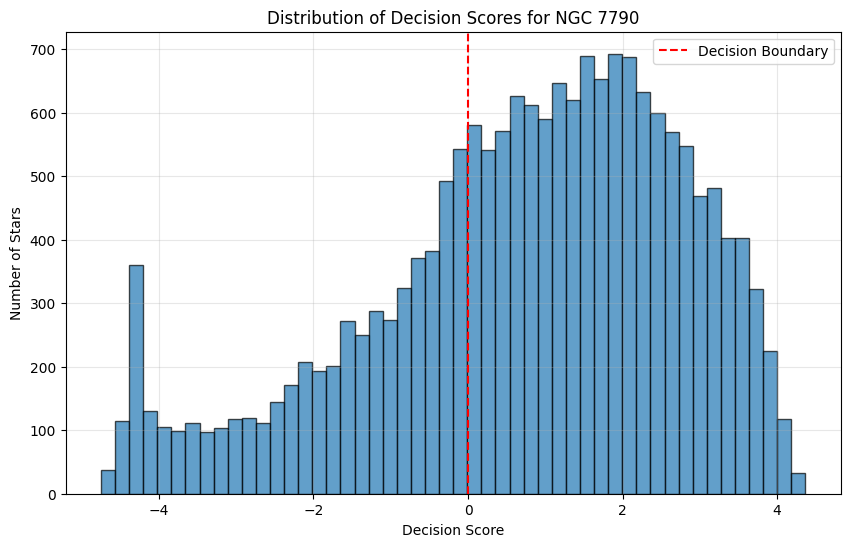

In [41]:
# Add predictions to cluster B dataframe
ngc_77_SVM = ngc_77.copy()
ngc_77_SVM['predicted_membership'] = cluster_B_predictions
ngc_77_SVM['decision_score'] = cluster_B_probabilities

# Summary of predictions
print("Cluster B Prediction Summary:")
print(f"Total stars: {len(cluster_B_predictions)}")
print(f"Predicted members: {np.sum(cluster_B_predictions)} ({np.mean(cluster_B_predictions)*100:.2f}%)")
print(f"Predicted non-members: {len(cluster_B_predictions) - np.sum(cluster_B_predictions)} ({(1-np.mean(cluster_B_predictions))*100:.2f}%)")

# Show some example predictions
print("\nSample predictions (first 10 stars):")
display_cols = feature_columns + ['predicted_membership', 'decision_score']
print(ngc_77_SVM[display_cols].head(10))

# Plot decision scores distribution
plt.figure(figsize=(10, 6))
plt.hist(ngc_77_SVM['decision_score'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
plt.xlabel('Decision Score')
plt.ylabel('Number of Stars')
plt.title('Distribution of Decision Scores for NGC 7790')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


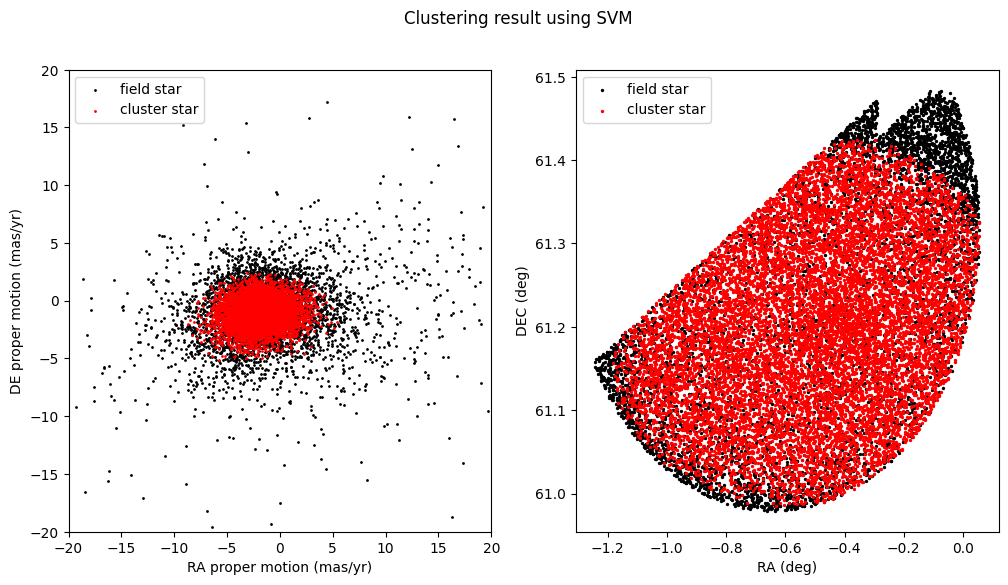

In [42]:
fig2, ax2 = plt.subplots(1,2,figsize=(12,6))
fig2.suptitle('Clustering result using SVM')

plt.sca(ax2[0])
plt.scatter(ngc_77_SVM[ngc_77_SVM.predicted_membership == 0]['pmRA'],ngc_77_SVM[ngc_77_SVM.predicted_membership == 0]['pmDE'],s=1,c='k',label='field star')
plt.scatter(ngc_77_SVM[ngc_77_SVM.predicted_membership == 1]['pmRA'],ngc_77_SVM[ngc_77_SVM.predicted_membership == 1]['pmDE'],s=1,c='r',label='cluster star')
plt.xlabel('RA proper motion (mas/yr)')
plt.ylabel('DE proper motion (mas/yr)')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.legend()

plt.sca(ax2[1])
plt.scatter(ngc_77_SVM[(ngc_77_SVM.predicted_membership == 0) & ( ngc_77_SVM._RAJ2000 < 180)]['_RAJ2000'],
            ngc_77_SVM[(ngc_77_SVM.predicted_membership == 0) & ( ngc_77_SVM._RAJ2000 < 180)]['_DEJ2000'],
            s=2,
            c='k',
            label='field star')
plt.scatter(ngc_77_SVM[(ngc_77_SVM.predicted_membership == 0) & ( ngc_77_SVM._RAJ2000 >= 180)]['_RAJ2000'] - 360,
            ngc_77_SVM[(ngc_77_SVM.predicted_membership == 0) & ( ngc_77_SVM._RAJ2000 >= 180)]['_DEJ2000'],
            s=2,
            c='k', )
plt.scatter(ngc_77_SVM[(ngc_77_SVM.predicted_membership == 1) & ( ngc_77_SVM._RAJ2000 < 180)]['_RAJ2000'],
            ngc_77_SVM[(ngc_77_SVM.predicted_membership == 1) & ( ngc_77_SVM._RAJ2000 < 180)]['_DEJ2000'],
            s=2,
            c='r',
            label='cluster star')
plt.scatter(ngc_77_SVM[(ngc_77_SVM.predicted_membership == 1) & ( ngc_77_SVM._RAJ2000 >= 180)]['_RAJ2000'] -360,
            ngc_77_SVM[(ngc_77_SVM.predicted_membership == 1) & ( ngc_77_SVM._RAJ2000 >= 180)]['_DEJ2000'],
            s=2,
            c='r',
            )
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

plt.show()


## HDBScan

HDBSCAN total labels (including noise): 5


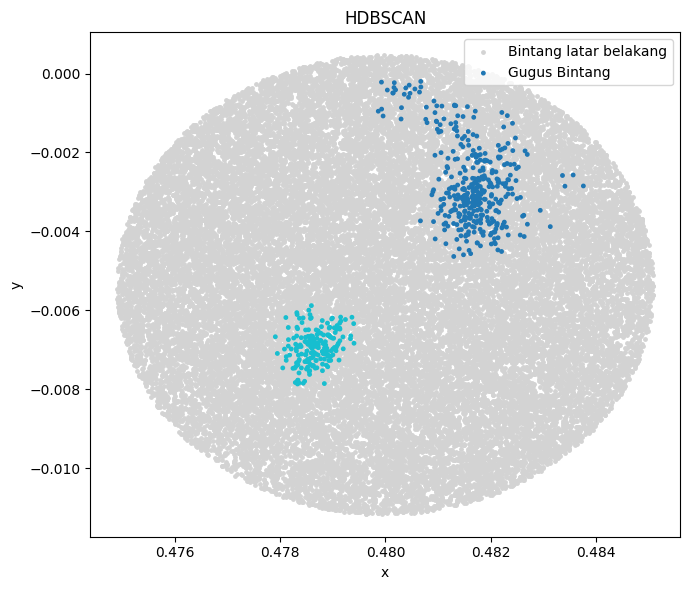

In [60]:
# Konversi RA/Dec ke koordinat kartesian
def radec_to_cartesian(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    return x, y, z

# Load data
ngc_77 = pd.read_csv('ngc7790_7788.csv')
ngc_77 = ngc_77[ngc_77['RUWE'] < 1.4]
ngc_77['x'], ngc_77['y'], ngc_77['z'] = radec_to_cartesian(ngc_77['_RAJ2000'], ngc_77['_DEJ2000'])

feature_columns = ['x', 'y', 'z', 'pmRA', 'pmDE', 'Plx']
ngc_77_clean = ngc_77.dropna(subset=feature_columns).copy()

X = ngc_77_clean[feature_columns].values
X_scaled = StandardScaler().fit_transform(X)

# HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=50)
ngc_77_clean['HDBSCAN'] = hdb.fit_predict(X_scaled)

# Hitung jumlah total label (termasuk noise)
hdb_n = len(set(ngc_77_clean['HDBSCAN']))
target_clusters = [0, 2]
cluster_members = ngc_77_clean[ngc_77_clean['HDBSCAN'].isin(target_clusters)]
print("HDBSCAN total labels (including noise):", hdb_n)

# Plot bintang latar belakang
plt.figure(figsize=(7, 6))
plt.scatter(ngc_77_clean['x'], ngc_77_clean['y'], color='lightgray', s=6, label='Bintang latar belakang')

# Plot hasil cluster
plt.scatter(cluster_members['x'], cluster_members['y'],c=cluster_members['HDBSCAN'], cmap='tab10', s=6, label='Gugus Bintang')

plt.title("HDBSCAN")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
# Calculate clustering evaluation metrics for HDBSCAN
# Exclude noise points (labeled -1) for these metrics
clustered_data = ngc_77_clean[ngc_77_clean['HDBSCAN'] != -1]

if len(clustered_data) > 1 and len(clustered_data['HDBSCAN'].unique()) > 1:
    X_clustered = StandardScaler().fit_transform(clustered_data[feature_columns].values)
    labels_clustered = clustered_data['HDBSCAN']

    hdbscan_sil_score = silhouette_score(X_clustered, labels_clustered)
    hdbscan_db_score = davies_bouldin_score(X_clustered, labels_clustered)
    hdbscan_ch_score = calinski_harabasz_score(X_clustered, labels_clustered)

    print(f"\nHDBSCAN Silhouette Score: {hdbscan_sil_score:.3f}")
    print(f"HDBSCAN Davies-Bouldin Index: {hdbscan_db_score:.3f}")
    print(f"HDBSCAN Calinski-Harabasz Score: {hdbscan_ch_score:.3f}")
else:
    print("\nNot enough clustered data points or clusters (excluding noise) to calculate evaluation metrics for HDBSCAN.")


HDBSCAN Silhouette Score: 0.441
HDBSCAN Davies-Bouldin Index: 0.881
HDBSCAN Calinski-Harabasz Score: 546.323


In [44]:
ngc_77_clean.HDBSCAN.unique()

array([-1,  1,  0,  3,  2])

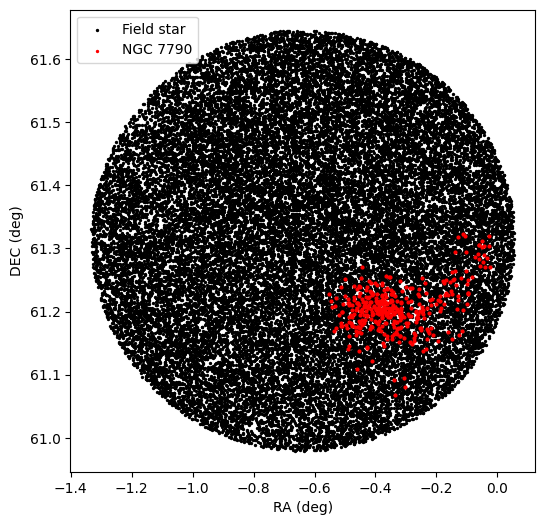

In [45]:
cluster_a = ngc_77_clean[ngc_77_clean.HDBSCAN == -1]
cluster_b = ngc_77_clean[ngc_77_clean.HDBSCAN == 0]
cluster_c = ngc_77_clean[ngc_77_clean.HDBSCAN == 1]
cluster_d = ngc_77_clean[ngc_77_clean.HDBSCAN == 2]
cluster_e = ngc_77_clean[ngc_77_clean.HDBSCAN == 3]

plt.figure(figsize=(6, 6))

plt.scatter(cluster_a.loc[cluster_a._RAJ2000 < 180]['_RAJ2000'],
            cluster_a.loc[cluster_a._RAJ2000 < 180]['_DEJ2000'],
            s=2,
            c='k',
            label='Field star')
plt.scatter(cluster_a.loc[cluster_a._RAJ2000 >= 180]['_RAJ2000'] -360,
            cluster_a.loc[cluster_a._RAJ2000 >= 180]['_DEJ2000'],
            s=2,
            c='k',)
plt.scatter(cluster_b.loc[cluster_b._RAJ2000 < 180]['_RAJ2000'],
            cluster_b.loc[cluster_b._RAJ2000 < 180]['_DEJ2000'],
            s=2,
            c='r',
            label='NGC 7790')
plt.scatter(cluster_b.loc[cluster_b._RAJ2000 >= 180]['_RAJ2000'] -360,
            cluster_b.loc[cluster_b._RAJ2000 >= 180]['_DEJ2000'],
            s=4,
            c='r',)





plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

In [46]:
cluster_b.to_csv('NGC7790_HDB.csv',index=False)

## KMeans

In [47]:
# data
def radec_to_cartesian(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)

    return x, y, z

ngc_77 = pd.read_csv('ngc7790_7788.csv')
ngc_77 = ngc_77.loc[ngc_77['RUWE'] < 1.4]
ngc_77['x'], ngc_77['y'], ngc_77['z'] = radec_to_cartesian(ngc_77['_RAJ2000'], ngc_77['_DEJ2000'])

feature_columns = ['x','y','z','pmRA', 'pmDE', 'Plx']
ngc_77 = ngc_77.dropna(subset=feature_columns).copy()

In [48]:
# Doing Kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features for KMeans
X = ngc_77[feature_columns]

# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

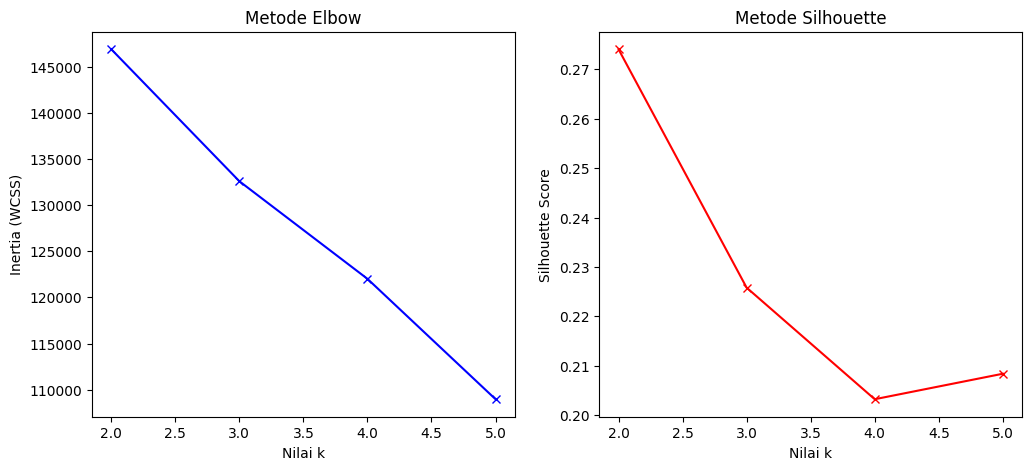

In [49]:
from sklearn.metrics import silhouette_score

inertia = []
silhouette_avg = []
K = range(2, 6) # Kita tes k=2 sampai k=5

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(X_scaled, labels))

# Plotting Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Nilai k')
plt.ylabel('Inertia (WCSS)')
plt.title('Metode Elbow')

# Plotting Silhouette
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_avg, 'rx-')
plt.xlabel('Nilai k')
plt.ylabel('Silhouette Score')
plt.title('Metode Silhouette')
plt.show()

Jumlah baris setelah filter RUWE: 32222
Jumlah baris setelah menghapus NaN dari kolom fitur: 11538

Jumlah bintang di setiap cluster (menggunakan fitur baru):
Cluster
0     300
1    5706
2    5532
Name: count, dtype: int64

Visualisasi 3D (x,y,z) disimpan sebagai cluster_visualization_3d_xyz.png


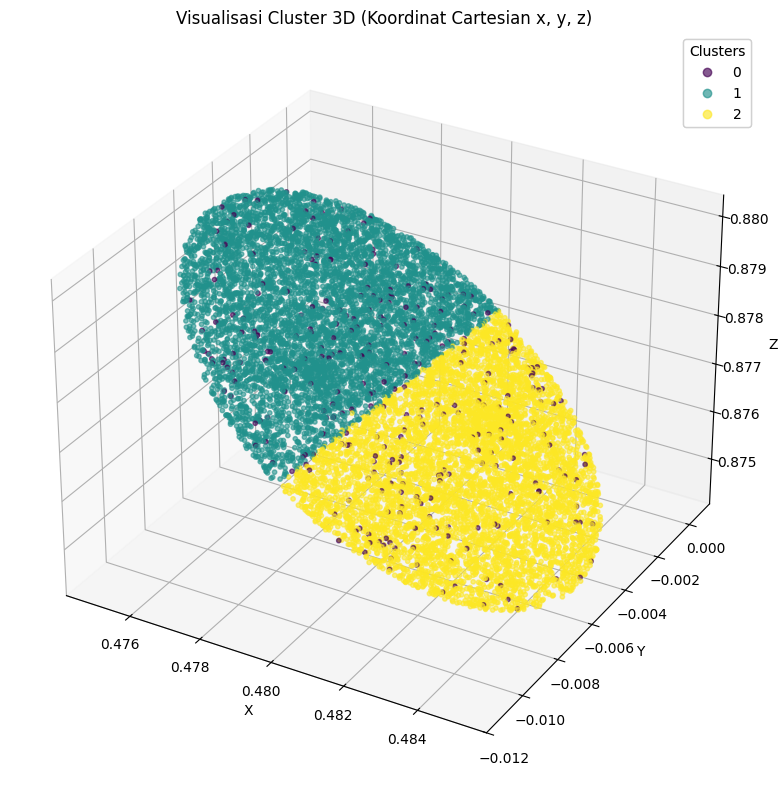

Visualisasi 2D (pmRA vs pmDE) disimpan sebagai cluster_visualization_2d_pm.png


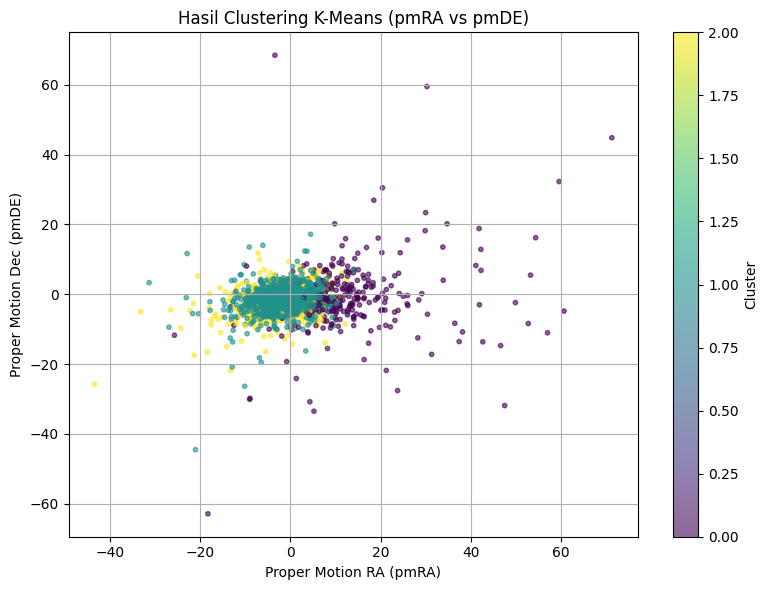

Visualisasi 2D (Plx vs [Fe/H]) disimpan sebagai cluster_visualization_2d_plx_feh.png


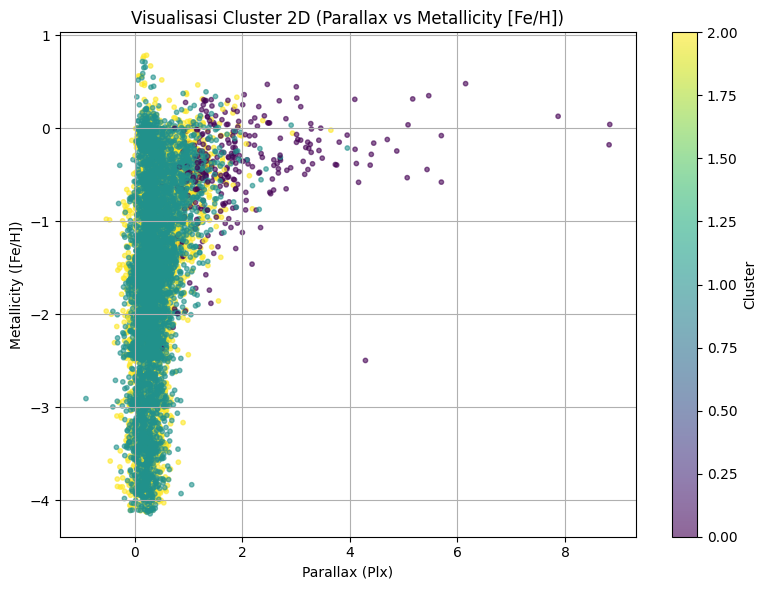


Data yang telah di-cluster (dari skrip ini) disimpan ke clustered_ngc7790_7788_script_output.csv


In [64]:
# Coba lagi
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Fungsi untuk konversi koordinat RA, Dec ke Cartesian
def radec_to_cartesian(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    return x, y, z

# 2. Memuat dataset
try:
    ngc_77 = pd.read_csv('ngc7790_7788.csv')
except FileNotFoundError:
    print("Pastikan file 'ngc7790_7788.csv' ada di direktori yang sama.")
    # exit() # Hapus atau komentari exit() jika dijalankan di lingkungan notebook

# 3. Filter data berdasarkan RUWE < 1.4
# Gunakan .copy() untuk menghindari SettingWithCopyWarning
ngc_77_filtered = ngc_77.loc[ngc_77['RUWE'] < 1.4].copy()

# 4. Menghitung koordinat Cartesian dan menambahkannya ke DataFrame
ngc_77_filtered['x'], ngc_77_filtered['y'], ngc_77_filtered['z'] = radec_to_cartesian(ngc_77_filtered['_RAJ2000'], ngc_77_filtered['_DEJ2000'])

# 5. Mendefinisikan kolom fitur untuk clustering
feature_columns = ['x', 'y', 'z', 'pmRA', 'pmDE', 'Plx', '[Fe/H]']
df_features = ngc_77_filtered[feature_columns]

# 6. Menangani nilai yang hilang (missing values)
#    Untuk kesederhanaan, kita akan menghapus baris dengan NaN pada kolom fitur yang dipilih
df_features_cleaned = df_features.dropna()
print(f"Jumlah baris setelah filter RUWE: {len(ngc_77_filtered)}")
print(f"Jumlah baris setelah menghapus NaN dari kolom fitur: {len(df_features_cleaned)}")

if len(df_features_cleaned) < 1000: # Cek jika data terlalu dikit
    print("Tidak cukup data setelah pembersihan untuk melakukan clustering.")
    # exit() # Hapus atau komentari exit()

# 7. Standardisasi data (fitur)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features_cleaned)

# 8. Menerapkan K-Means clustering
#    Kita akan menggunakan 3 cluster seperti sebelumnya.
#    random_state digunakan untuk reproduktifitas, n_init='auto' untuk versi sklearn yang lebih baru.
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# 9. Menambahkan label cluster ke DataFrame yang bersih
df_clustered = df_features_cleaned.copy()
df_clustered['Cluster'] = clusters

# --- Informasi Hasil Clustering ---
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
print("\nJumlah bintang di setiap cluster (menggunakan fitur baru):")
print(cluster_counts)

# --- Visualisasi Cluster ---

# A. Visualisasi 3D Scatter Plot (x, y, z)
fig3d = plt.figure(figsize=(10, 8))
ax3d = fig3d.add_subplot(111, projection='3d')
scatter3d = ax3d.scatter(df_clustered['x'], df_clustered['y'], df_clustered['z'],
                         c=df_clustered['Cluster'], cmap='viridis', marker='o', s=10, alpha=0.6)
ax3d.set_title('Visualisasi Cluster 3D (Koordinat Cartesian x, y, z)')
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')
legend1 = ax3d.legend(*scatter3d.legend_elements(), title="Clusters")
ax3d.add_artist(legend1)
plt.tight_layout()
plot_3d_filename = 'cluster_visualization_3d_xyz.png'
plt.savefig(plot_3d_filename)
print(f"\nVisualisasi 3D (x,y,z) disimpan sebagai {plot_3d_filename}")
plt.show() # Tampilkan plot jika diinginkan
plt.close(fig3d)

# B. Visualisasi 2D Scatter Plot (pmRA vs pmDE)
fig2d_pm = plt.figure(figsize=(8, 6))
scatter_pm = plt.scatter(df_clustered['pmRA'], df_clustered['pmDE'],
                         c=df_clustered['Cluster'], cmap='viridis', marker='o', s=10, alpha=0.6)
plt.title('Hasil Clustering K-Means (pmRA vs pmDE)')
plt.xlabel('Proper Motion RA (pmRA)')
plt.ylabel('Proper Motion Dec (pmDE)')
plt.colorbar(scatter_pm, label='Cluster')
plt.grid(True)
plt.tight_layout()
plot_2d_pm_filename = 'cluster_visualization_2d_pm.png'
plt.savefig(plot_2d_pm_filename)
print(f"Visualisasi 2D (pmRA vs pmDE) disimpan sebagai {plot_2d_pm_filename}")
plt.show() # Tampilkan plot jika diinginkan
plt.close(fig2d_pm)

# C. Visualisasi 2D Scatter Plot (Plx vs [Fe/H])
if '[Fe/H]' in df_clustered.columns and df_clustered['[Fe/H]'].nunique() > 1 and \
   'Plx' in df_clustered.columns and df_clustered['Plx'].nunique() > 1:
    fig2d_plx_feh = plt.figure(figsize=(8, 6))
    scatter_plx_feh = plt.scatter(df_clustered['Plx'], df_clustered['[Fe/H]'],
                                  c=df_clustered['Cluster'], cmap='viridis', marker='o', s=10, alpha=0.6)
    plt.title('Visualisasi Cluster 2D (Parallax vs Metallicity [Fe/H])')
    plt.xlabel('Parallax (Plx)')
    plt.ylabel('Metallicity ([Fe/H])')
    plt.colorbar(scatter_plx_feh, label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plot_2d_plx_feh_filename = 'cluster_visualization_2d_plx_feh.png'
    plt.savefig(plot_2d_plx_feh_filename)
    print(f"Visualisasi 2D (Plx vs [Fe/H]) disimpan sebagai {plot_2d_plx_feh_filename}")
    plt.show() # Tampilkan plot jika diinginkan
    plt.close(fig2d_plx_feh)
else:
    print("Tidak dapat membuat plot Plx vs [Fe/H] karena data tidak mencukupi atau kolom tidak ada.")

# Menyimpan DataFrame yang sudah di-cluster
output_filename_script = 'clustered_ngc7790_7788_script_output.csv'
ngc_77_clustered_output_script = ngc_77_filtered.loc[df_clustered.index].copy()
ngc_77_clustered_output_script['Cluster'] = df_clustered['Cluster']
ngc_77_clustered_output_script.to_csv(output_filename_script, index=False)
print(f"\nData yang telah di-cluster (dari skrip ini) disimpan ke {output_filename_script}")

In [65]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

db_score = davies_bouldin_score(X_scaled, clusters)
sil_score = silhouette_score(X_scaled, clusters)
ch_score = calinski_harabasz_score(X_scaled, clusters)

print(f"K-Means Silhouette Score: {sil_score:.3f}")
print(f"K-Means Davies-Bouldin Index: {db_score:.3f}")
print(f"K-Means Calinski-Harabasz Score: {ch_score:.3f}")

K-Means Silhouette Score: 0.249
K-Means Davies-Bouldin Index: 1.414
K-Means Calinski-Harabasz Score: 2579.740
